## Import Modules

In [108]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [3]:
BASE_DIR = ''
WORKING_DIR = ''

## Extract Image Features

In [114]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


# extract features from image


In [7]:
features = {}
directory = os.path.join(BASE_DIR, 'Images')
n=1
for img_name in tqdm(os.listdir(directory)):
    print(n)
    n+=1
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8099 [00:00<?, ?it/s]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x000001B95A975B70>

In [8]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

## load features from saved pickle file

In [115]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

## Load the Captions Data

In [125]:
with open(os.path.join(BASE_DIR, 'Text/Flickr8k.token.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [126]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split('\t')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40460 [00:00<?, ?it/s]

### creating mapping of image prefix to captions

In [180]:
len(mapping)
mapping['811663364_4b350a62ce']

['startseq a girl in a pink swimsuit jumps through a water sprinkler endseq',
 'startseq a little girl in a swimsuit jumps over a sprinkler with her eyes hut endseq',
 'startseq a little girl running through yellow sprinkler in a grassy yard endseq',
 'startseq a young girl running through a sprinkler endseq',
 'startseq little girl in pink bathing suit jumping through a sprinkler toy outside endseq']

## Preprocess Text Data

In [128]:
import re

def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc.,
            caption = re.sub(r'[^a-zA-Z]', ' ', caption)
            # replace multiple whitespaces with a single space
            caption = re.sub(r'\s+', ' ', caption)
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if word in ['a', 'i'] or len(word) > 1]) + ' endseq'
            captions[i] = caption


In [53]:
# def clean(mapping):
#     for key, captions in mapping.items():
#         for i in range(len(captions)):
#             # take one caption at a time
#             caption = captions[i]
#             # preprocessing steps
#             # convert to lowercase
#             caption = caption.lower()
#             # delete digits, special chars, etc., 
#             caption = caption.replace('[~A-Za-z]', '')
#             # delete additional spaces
#             caption = caption.replace('\s+', ' ')
#             # add start and end tags to the caption
#             caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>=1]) + ' endseq'
#             captions[i] = caption

In [129]:
# before preprocess of text
mapping['2185793891_5a5e903ca6']

["A baby cries in a woman 's arms .",
 'A baby in a red shirt is crying while an adult holding the baby mocks it .',
 'A baby wearing red begins to cry as a woman makes a face at it .',
 'a little baby cries in his moms arms .',
 "A woman is holding onto a baby that looks like he 's about to cry ."]

In [130]:
# preprocess the text
clean(mapping)

In [131]:
# after preprocess of text
mapping['2185793891_5a5e903ca6']

['startseq a baby cries in a woman arms endseq',
 'startseq a baby in a red shirt is crying while an adult holding the baby mocks it endseq',
 'startseq a baby wearing red begins to cry as a woman makes a face at it endseq',
 'startseq a little baby cries in his moms arms endseq',
 'startseq a woman is holding onto a baby that looks like he about to cry endseq']

In [132]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [133]:
len(all_captions)

40459

In [134]:
all_captions[:10]

['startseq a girl going into a wooden building endseq',
 'startseq a little girl climbing into a wooden playhouse endseq',
 'startseq a little girl climbing the stairs to her playhouse endseq',
 'startseq a little girl in a pink dress going into a wooden cabin endseq',
 'startseq a black dog and a spotted dog are fighting endseq',
 'startseq a black dog and a tri colored dog playing with each other on the road endseq',
 'startseq a black dog and a white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq',
 'startseq a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl endseq']

In [109]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [110]:
vocab_size

8428

In [111]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

38

## Train Test Split

In [20]:
# image_ids = list(mapping.keys())
# split = int(len(image_ids) * 0.90)
# train = image_ids[:split]
# test = image_ids[split:]

In [138]:
import random
image_ids = list(mapping.keys())
random.shuffle(image_ids)
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [21]:
# startseq girl going into wooden building endseq
#        X                   y
# startseq                   girl
# startseq girl              going
# startseq girl going        into
# ...........
# startseq girl going into wooden building      endseq

In [146]:
# # create data generator to get data in batch (avoids session crash)
# def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
#     # loop over images
#     X1, X2, y = list(), list(), list()
#     n = 0
#     while 1:
#         for key in data_keys:
#             n += 1
#             captions = mapping[key]
#             # process each caption
#             for caption in captions:
#                 # encode the sequence
#                 seq = tokenizer.texts_to_sequences([caption])[0]
#                 # split the sequence into X, y pairs
#                 for i in range(1, len(seq)):
#                     # split into input and output pairs
#                     in_seq, out_seq = seq[:i], seq[i]
#                     # pad input sequence
#                     in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
#                     # encode output sequence
#                     out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
#                     # store the sequences
#                     X1.append(features[key][0])
#                     X2.append(in_seq)
#                     y.append(out_seq)
#             if n == batch_size:
#                 X1, X2, y = np.array(X1), np.array(X2), np.array(y)
#                 yield {"image": X1, "text": X2}, y
#                 X1, X2, y = list(), list(), list()
#                 n = 0
import os

def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size, image_dir):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            # Check if image file exists
            image_path = os.path.join(image_dir, key + '.jpg')
            if not os.path.exists(image_path):
                continue  # Skip if image file does not exist
            
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0


## Model Creation

In [64]:
vocab_size = 8428
max_length = 38

In [65]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


# training

In [157]:
# train the model
epochs = 20
batch_size = 32
steps = int((len(train)) // batch_size)

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size,'Images')
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 ━━━━━━━━━━━━━━━━━━━━ 411s 2s/step - loss: 5.3746
227/227 ━━━━━━━━━━━━━━━━━━━━ 379s 2s/step - loss: 3.5656
227/227 ━━━━━━━━━━━━━━━━━━━━ 373s 2s/step - loss: 3.1336
227/227 ━━━━━━━━━━━━━━━━━━━━ 381s 2s/step - loss: 2.8889
227/227 ━━━━━━━━━━━━━━━━━━━━ 395s 2s/step - loss: 2.7116
227/227 ━━━━━━━━━━━━━━━━━━━━ 408s 2s/step - loss: 2.5764
227/227 ━━━━━━━━━━━━━━━━━━━━ 406s 2s/step - loss: 2.4734
227/227 ━━━━━━━━━━━━━━━━━━━━ 408s 2s/step - loss: 2.3953
227/227 ━━━━━━━━━━━━━━━━━━━━ 430s 2s/step - loss: 2.3260
227/227 ━━━━━━━━━━━━━━━━━━━━ 428s 2s/step - loss: 2.2676
227/227 ━━━━━━━━━━━━━━━━━━━━ 427s 2s/step - loss: 2.2174
227/227 ━━━━━━━━━━━━━━━━━━━━ 463s 2s/step - loss: 2.1730
227/227 ━━━━━━━━━━━━━━━━━━━━ 474s 2s/step - loss: 2.1342
227/227 ━━━━━━━━━━━━━━━━━━━━ 484s 2s/step - loss: 2.0944
227/227 ━━━━━━━━━━━━━━━━━━━━ 497s 2s/step - loss: 2.0608
227/227 ━━━━━━━━━━━━━━━━━━━━ 511s 2s/step - loss: 2.0278
227/227 ━━━━━━━━━━━━━━━━━━━━ 506s 2s/step - loss: 1.9942
227/227 ━━━━━━━━━━━━━━━━━━━━ 68

In [160]:
# save the model
model.save('best_model.h5')

# model definition and loading

In [112]:
from keras.models import load_model
from tensorflow.keras.models import Sequential, model_from_json
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(38,), name="text")
se1 = Embedding(8428, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(8428, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

model.load_weights('best_model.h5')





## Generate Captions for the Image

In [113]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [114]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

# calculation of bleu score against test set

In [115]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.658807
BLEU-2: 0.485955


## Visualize the Results

In [116]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq a man is wearing a sooners red football shirt and helmet endseq
startseq a oklahoma sooners football player wearing his jersey number endseq
startseq a sooners football player weas the number and black armbands endseq
startseq guy in red and white football uniform endseq
startseq the american footballer is wearing a red and white strip endseq
--------------------Predicted--------------------
startseq a football layer in action endseq


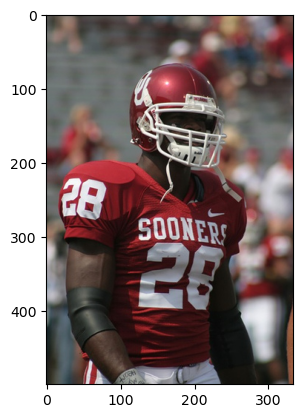

In [117]:
generate_caption("241347760_d44c8d3a01.jpg")

---------------------Actual---------------------
startseq a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl endseq
startseq a little girl is sitting in front of a large painted rainbow endseq
startseq a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it endseq
startseq there is a girl with pigtails sitting in front of a rainbow painting endseq
startseq young girl with pigtails painting outside in the grass endseq
--------------------Predicted--------------------
startseq a girl in a red jacket stands in front of a red fence endseq


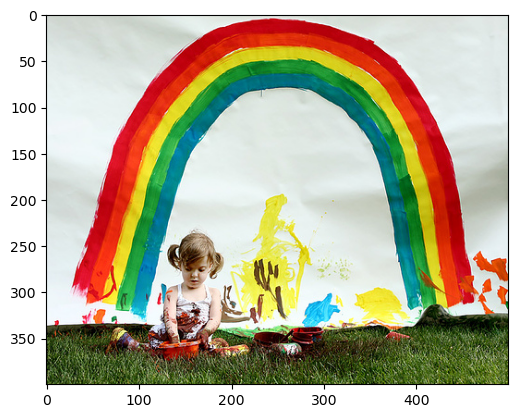

In [166]:
generate_caption("1002674143_1b742ab4b8.jpg")

---------------------Actual---------------------
startseq a man in a hat is displaying pictures next to a skier in a blue hat endseq
startseq a man skis past another man displaying paintings in the snow endseq
startseq a person wearing skis looking at framed pictures set up in the snow endseq
startseq a skier looks at framed pictures in the snow next to trees endseq
startseq man on skis looking at artwork for sale in the snow endseq
--------------------Predicted--------------------
startseq a man standing on the snow endseq


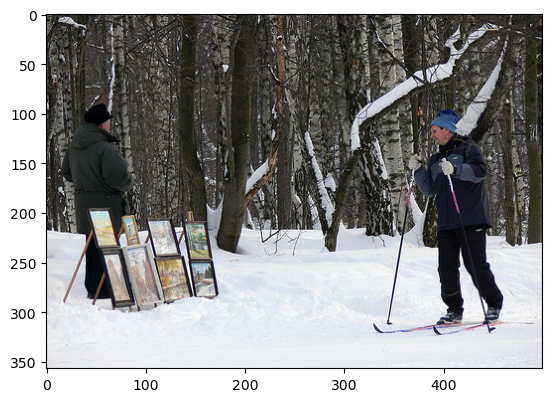

In [170]:
generate_caption("101669240_b2d3e7f17b.jpg")

## Test with Real Image

In [152]:
vgg_model = VGG16()
# restructure the model
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

'startseq a group of people are sitting in a row endseq'

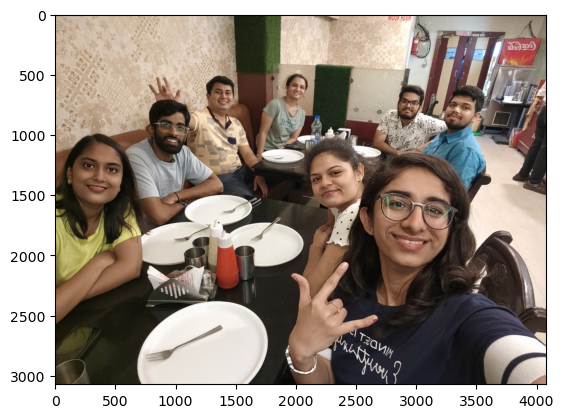

In [160]:
image_path = 'group.jpg'
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
image = Image.open(image_path)
plt.imshow(image)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)

'startseq a man and a man are sitting in a subway endseq'

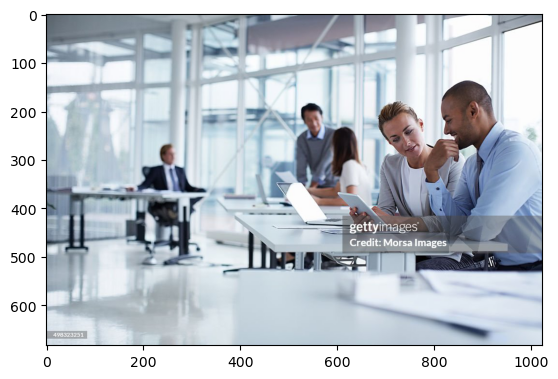

In [165]:
image_path = 'getty.jpg'
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
image = Image.open(image_path)
plt.imshow(image)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)

'startseq a man is skiing down a snowy hill endseq'

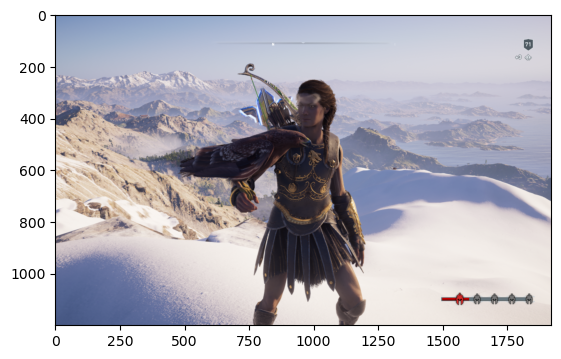

In [157]:
image_path = 'Screenshot.jpg'
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
image = Image.open(image_path)
plt.imshow(image)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)

In [134]:
predictedsentence = []
for sentence in predicted:
    sen = ''
    for word in sentence[1:-1]:
        sen = sen + word + ' '
    predictedsentence.append(sen)

In [135]:
predictedsentence

['a man wearing a hat is firing a gun in a city ',
 'a man is walking down a sidewalk with a bicycle in the background ',
 'a smiling girl in a blue jacket and glasses is running in a wooded area ',
 'a man wearing a black jacket and glasses looks down ',
 'a man with a brown and white and white jacket is holding a stick ',
 'a dog jumps over a hurdle ',
 'a soccer player in red is chasing a soccer ball ',
 'a man is standing on a beach with a man in a blue shirt and hat ',
 'a baseball player in a red shirt is trying to throw a baseball ',
 'a man in a red had is climbing a rock wall ',
 'a man in a black shirt and tie is talking to a man in a black shirt ',
 'a basketball player is jumping for the ball ',
 'a man talks on a cellphone while he talks on a cellphone ',
 'a group of people are gathered outside a frisbee ',
 'a man in a helmet is climbing up a rock ',
 'a snowboarder is jumping over a snowy hill ',
 'a girl in a blue shirt is jumping in a blue house ',
 'a man eats a dog 

In [166]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# Load pre-trained GPT-2 tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
print("xy")
model = GPT2LMHeadModel.from_pretrained("gpt2")


xy


In [167]:
# Concatenate image-caption pairs into input sequences
import torch
model.eval()
temperature = 3
top_k = 40
def generate_story(image_caption_pairs):
    # Load pretrained GPT-2 model and tokenizer
    tokenizer.pad_token = tokenizer.eos_token  # Set padding token to end-of-sequence token

    # Set device to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print(device)
    # Set maximum length for generated text
    max_length = 100

    # Generate stories for each image-caption pair
    generated_stories = []
    for image_caption_pair in image_caption_pairs:
        # Tokenize and encode the image caption
        input_text = f" {image_caption_pair} "
        input_ids = tokenizer.encode(input_text, return_tensors="pt", padding=True, truncation=True).to(device)

        # Generate text based on the input
        with torch.no_grad():
            output_ids = model.generate(input_ids, max_length=max_length, num_beams = 5, no_repeat_ngram_size = 2, early_stopping = True, temperature=temperature, top_k=top_k, num_return_sequences=1)

        # Decode the generated text
        generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
        generated_stories.append(generated_text)

    return generated_stories

# Example usage:
image_caption_pairs = predictedsentence

generated_stories = generate_story(image_caption_pairs)
n=0
for i, story in enumerate(generated_stories):
    n+=1
    if n % 100 == 0 :
        print(f"Generated Story {i+1}: {story}\n")

C:\Users\hi\anaconda3\Lib\site-packages\transformers\generation\configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `3` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
C:\Users\hi\anaconda3\Lib\site-packages\transformers\generation\configuration_utils.py:509: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `40` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


cuda


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generati

Generated Story 100:  a man walks down a sidewalk in a park   with his wife and two young children. He is wearing a white T-shirt with the words "I love you" on the front and a black hooded sweatshirt over his head. The man, who has not been identified, is dressed in an orange jumpsuit, black pants, and white sneakers. His face is covered in tattoos on his arms, chest, back, shoulders, arms and legs.
The man's wife,

Generated Story 200:  a woman palm his hair as he is reaching into a window   and pulls out a small piece of paper.
"What is this?" he asks. "It's a picture of me."
The woman looks at him and says, "I don't know what you're talking about, but I'm going to take this picture and put it up on the internet. I want you to know that I love you, and that you are my best friend and I will never let you

Generated Story 300:  a dog is running through snow ?"

"No, I don't think so. It's just that I'm not sure what to do with it. I think I'll just leave it at home. If I can't find i

In [168]:
from nltk.translate.bleu_score import corpus_bleu

# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, generated_stories, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, generated_stories, weights=(0.5, 0.5, 0, 0)))

C:\Users\hi\anaconda3\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\hi\anaconda3\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\hi\anaconda3\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

BLEU-1: 0.006974
BLEU-2: 0.000000


In [169]:
tense = [sentence.split() for sentence in generated_stories]

In [174]:
tense

[['a',
  'man',
  'wearing',
  'a',
  'hat',
  'is',
  'firing',
  'a',
  'gun',
  'in',
  'a',
  'city',
  'that',
  'has',
  'a',
  'population',
  'of',
  'about',
  '1.5',
  'million',
  'people.',
  'This',
  'is',
  'not',
  'the',
  'first',
  'time',
  'that',
  'this',
  'has',
  'happened.',
  'In',
  '2011,',
  'a',
  'woman',
  'was',
  'shot',
  'and',
  'killed',
  'by',
  'a',
  'group',
  'of',
  'men',
  'who',
  'were',
  'trying',
  'to',
  'break',
  'into',
  'her',
  'home.',
  'The',
  'man',
  'who',
  'shot',
  'her',
  'was',
  'convicted',
  'of',
  'murder',
  'and',
  'sentenced',
  'to',
  'life',
  'in',
  'prison.',
  'In',
  '2012,',
  'an',
  '18-year-old',
  'man',
  'was',
  'charged',
  'with',
  'attempted',
  'murder',
  'in',
  'the',
  'death',
  'of',
  'his'],
 ['a',
  'man',
  'is',
  'walking',
  'down',
  'a',
  'sidewalk',
  'with',
  'a',
  'bicycle',
  'in',
  'the',
  'background',
  'and',
  'a',
  'woman',
  'is',
  'standing',
  'in'

In [171]:
print("BLEU-1: %f" % corpus_bleu(actual, tense, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, tense, weights=(0.5, 0.5, 0, 0)))

BLEU-1: 0.135023
BLEU-2: 0.081822


In [175]:
for i in generated_stories:
    print(i)

 a man wearing a hat is firing a gun in a city   that has a population of about 1.5 million people.
This is not the first time that this has happened. In 2011, a woman was shot and killed by a group of men who were trying to break into her home. The man who shot her was convicted of murder and sentenced to life in prison. 
In 2012, an 18-year-old man was charged with attempted murder in the death of his
 a man is walking down a sidewalk with a bicycle in the background   and a woman is standing in front of him with her back to the camera.
"I don't know what to do," she says, "but I'm going to get out of here."
I ask her if she has any idea what's going on. She says she doesn't, and that she's not sure what she should do. I tell her that I have no idea how to deal with this
 a smiling girl in a blue jacket and glasses is running in a wooded area   in the middle of the woods. 
I'm not sure if this is the first time I've seen this kind of thing, but I'm pretty sure it's one of my favorite

In [177]:
# Concatenate image-caption pairs into input sequences
import torch
model.eval()
temperature = 3
top_k = 40
def generate_story(image_caption_pairs):
    # Load pretrained GPT-2 model and tokenizer
    tokenizer.pad_token = tokenizer.eos_token  # Set padding token to end-of-sequence token

    # Set device to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print(device)
    # Set maximum length for generated text
    max_length = 40

    # Generate stories for each image-caption pair
    generated_stories = []
    for image_caption_pair in image_caption_pairs:
        # Tokenize and encode the image caption
        input_text = f" {image_caption_pair} "
        input_ids = tokenizer.encode(input_text, return_tensors="pt", padding=True, truncation=True).to(device)

        # Generate text based on the input
        with torch.no_grad():
            output_ids = model.generate(input_ids, max_length=max_length, num_beams = 5, no_repeat_ngram_size = 2, early_stopping = True, temperature=temperature, top_k=top_k, num_return_sequences=1)

        # Decode the generated text
        generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
        generated_stories.append(generated_text)

    return generated_stories

# Example usage:
image_caption_pairs = predictedsentence

new_stories = generate_story(image_caption_pairs)
n=0
for i, story in enumerate(new_stories):
    n+=1
    if n % 100 == 0 :
        print(f"Generated Story {i+1}: {story}\n")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


cuda


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generati

Generated Story 100:  a man walks down a sidewalk in a park   with his wife and two young children. He is wearing a white T-shirt with the words "I love you" written on it.

Generated Story 200:  a woman palm his hair as he is reaching into a window   and pulls out a small piece of paper.
"What is this?" he asks. "It's a picture of a

Generated Story 300:  a dog is running through snow ?"

"No, I don't think so. It's just that I'm not sure what to do with it. I think it's going to

Generated Story 400:  a ragged man sleeping on a chair   in the middle of the night.
I'm not going to lie, I was really excited when I saw this picture. It was so beautiful

Generated Story 500:  a man wearing a hat and a hat talks on a cellphone   with a woman who is in a car with him. The woman asks him if he wants to talk to her, and he

Generated Story 600:  a hiker is walking on a snowy hill   and you can see the snow on the ground. The snow is so thick that it's almost impossible to see through it.
The

In [178]:
tensa = [sentence.split() for sentence in new_stories]

In [179]:
print("BLEU-1: %f" % corpus_bleu(actual, tensa, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, tensa, weights=(0.5, 0.5, 0, 0)))

BLEU-1: 0.279076
BLEU-2: 0.178170
